In [1]:
import sys
sys.path.append(["./", "../", "../../"])
from FeatureLibrary import FeatureLibrary
from Helpers.getECSubtypes import getECSubtypes
from plots.ResponseCurvePlots import plotRCClassified, plotRCAnomalies
import numpy as np
import matplotlib.pyplot as plt

In [2]:
libraryPath = "./"
IDDataPath = "../Helpers/jsonFiles/"
testPath = "../../data/"
allSubtypes = getECSubtypes()
library = FeatureLibrary(libraryPath, IDDataPath, testPath, allSubtypes)

In [3]:
allFeatures = library.getFeatures()
print("All features:", allFeatures)
featuredHybrids = library.getHybrids("FEATURE", "R1H1")
print(len(featuredHybrids))

All features: ['CLONED', 'SLOPE', 'DISC', 'STRSLOPE', 'COLD', 'FEATURE', 'ALLBAD', 'SPECIAL']
4


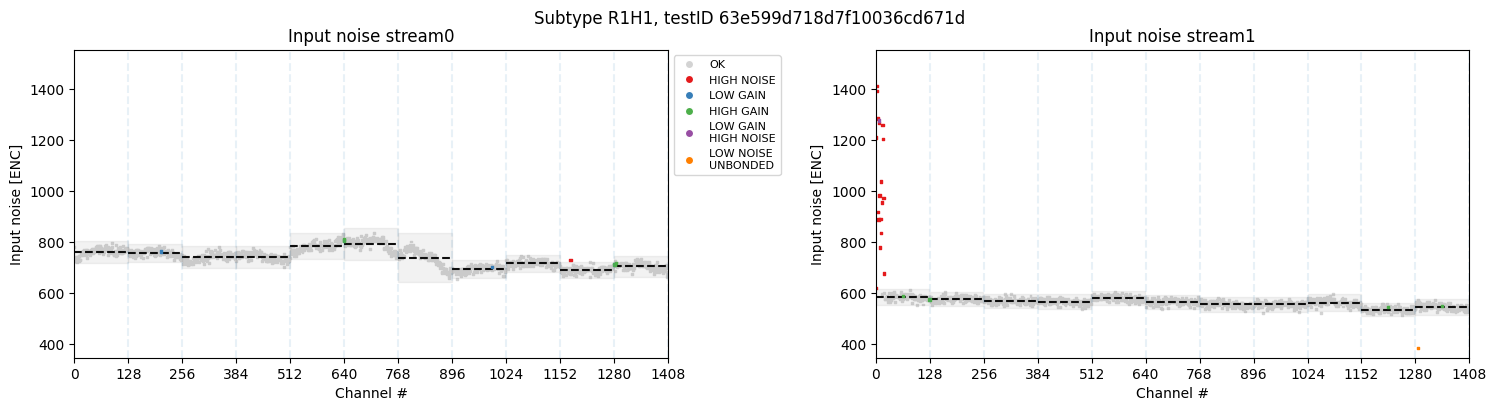

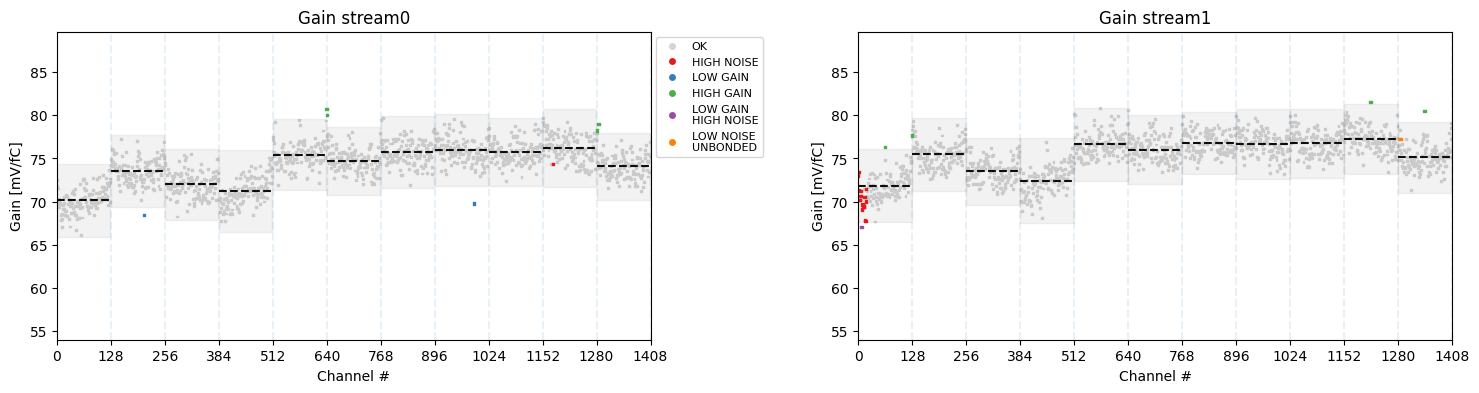

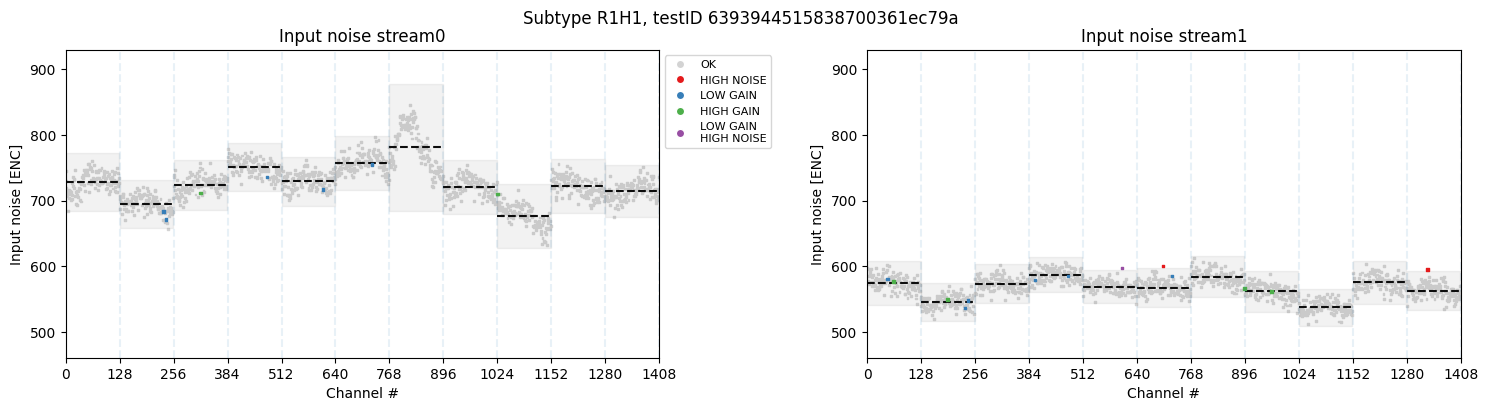

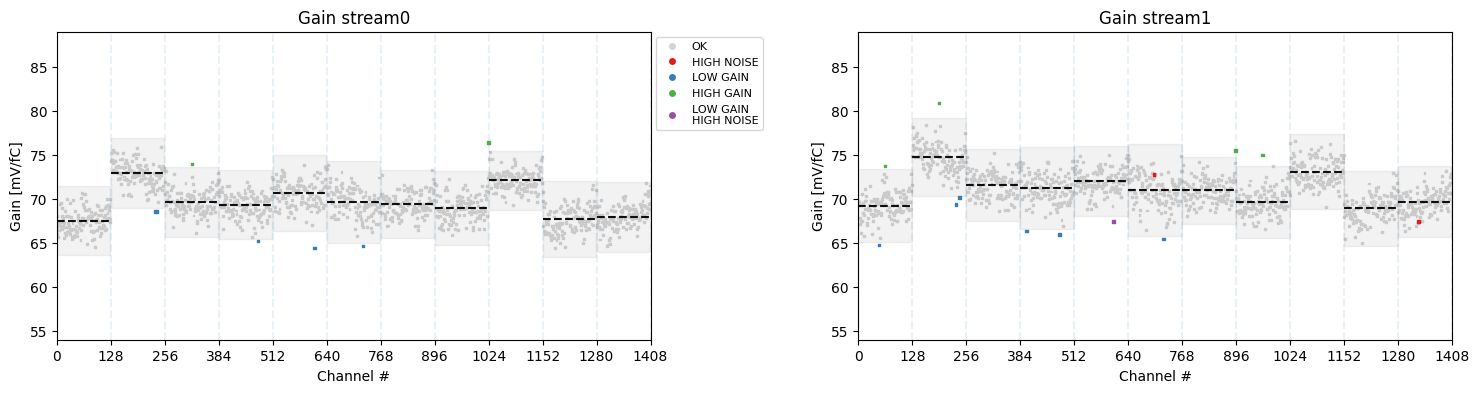

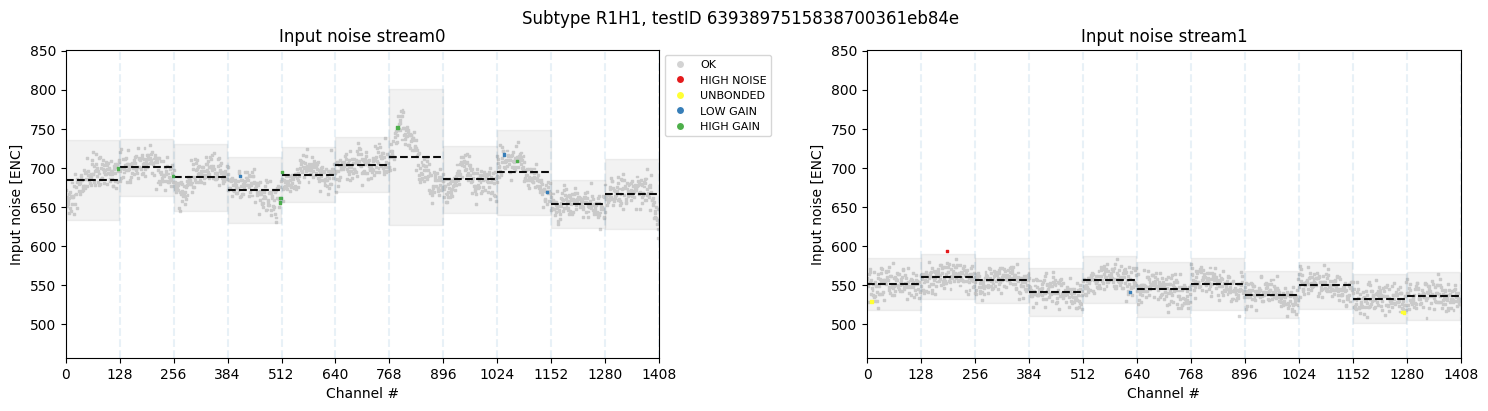

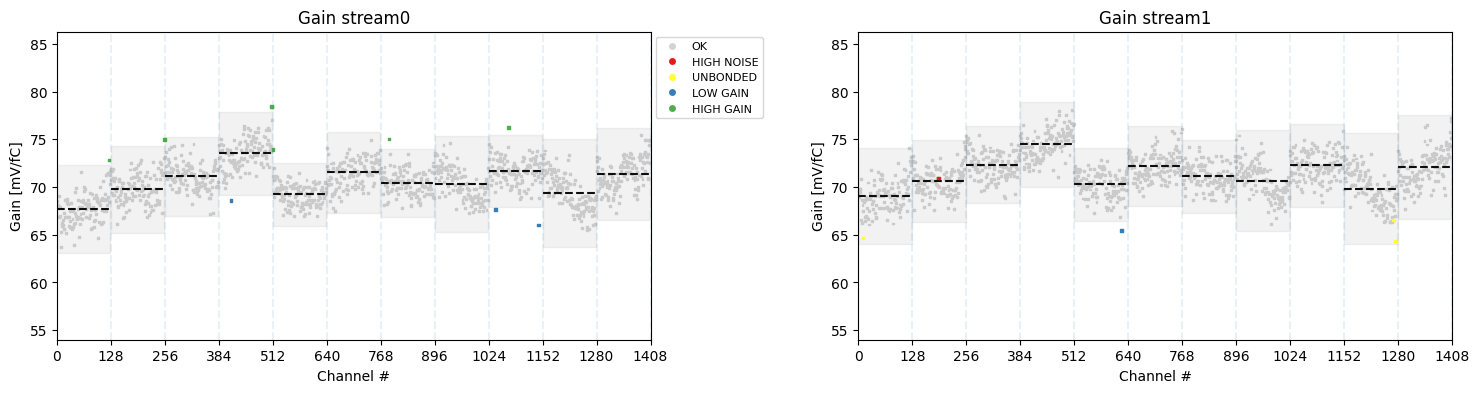

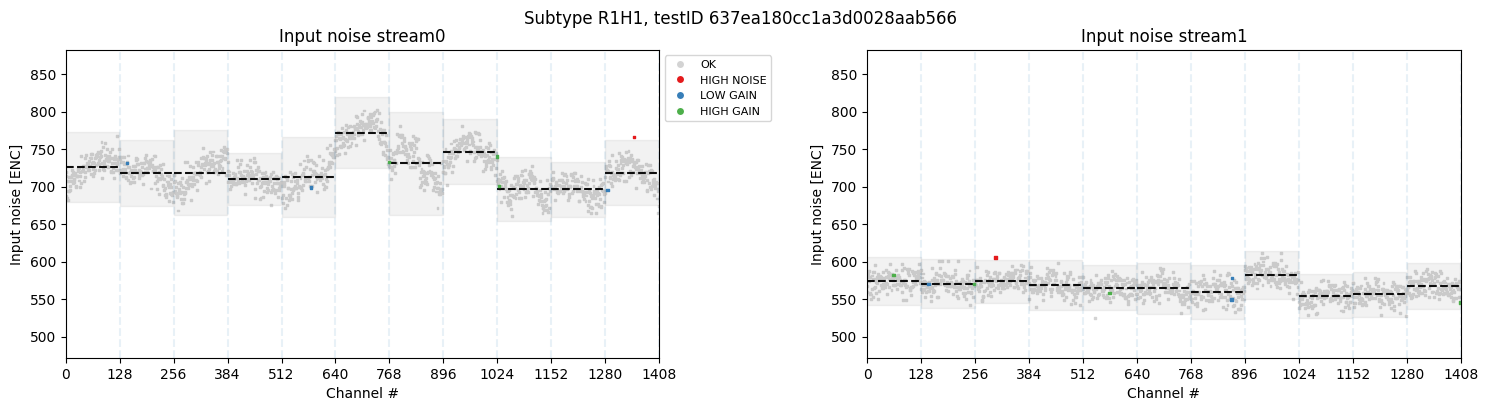

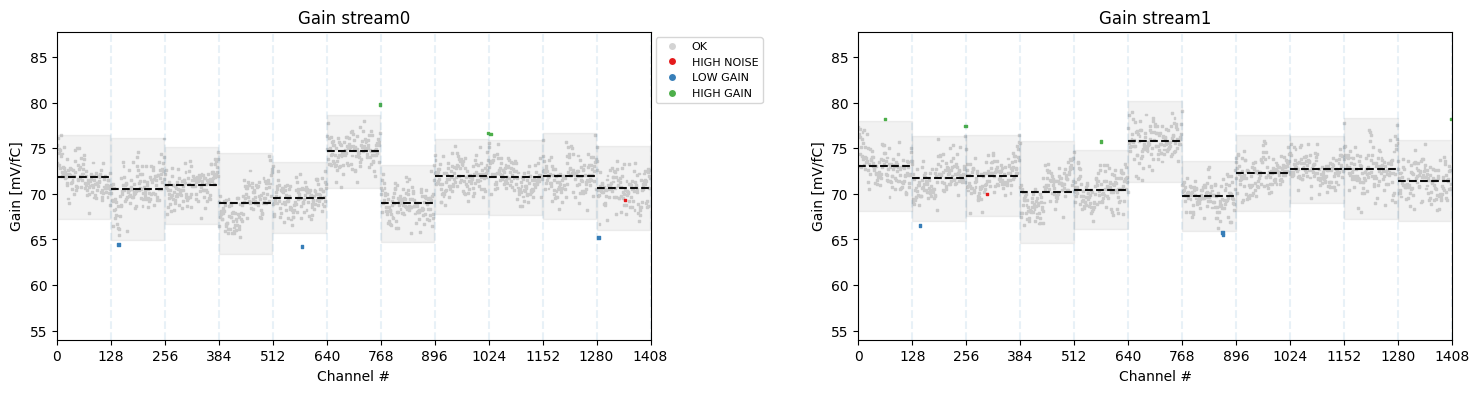

In [4]:
for hybrid in featuredHybrids:
    hybrid.classification()
    fig, axs = plotRCClassified(hybrid, "innse", detectAnomalies=False, showStats=True)
    _, _ = plotRCClassified(hybrid, "gain", detectAnomalies=False, minValue=60, showStats=True)
    fig.suptitle("Subtype " + hybrid.subtype + ", testID " + hybrid.testID)

In [5]:
def printW(hybrid):
    stream = 0
    for c, chip in enumerate(hybrid.chips):
        channels = [channel for channel in chip.getStream(stream) if not channel.badchannel]
        leftChannels = channels[:len(channels)//2]
        rightChannels = channels[len(channels)//2:]
        mean = chip.meanOutnse(stream=stream, countbadchannels=False)
        sLeft = 0
        sRight = 0

        values = [channel.outnse for channel in leftChannels[-1:0:-1]]
        xs = [x / len(leftChannels) for x in range(len(leftChannels))]
        ys = [y - mean for y in values]
        yMean = np.mean(np.abs(ys))
        ys = np.array(ys) / yMean
        ws = [x * y for x, y in zip(xs, ys)]
        sLeft = sum(ws)
        #for x, channel in enumerate(leftChannels[-1:0:-1]):
        #    value = channel.outnse
        #    y = value - mean
        #    w = (x / len(leftChannels)) * y
        #    sLeft += w

        for x, channel in enumerate(rightChannels):
            value = channel.outnse
            y = value - mean
            w = (x / len(rightChannels)) * y
            sRight += w

        print(f"{c}: {sLeft:>6.1f}, {sRight:>6.1f}, {sLeft - sRight:>6.1f},  {sLeft + sRight:>6.1f}")

sum(x_i * [y_i - M]) = sum(x_i * [k * x_i + m - M]) = sum(x_i * [k * x_i + c]) = sum(k * x²_i + c * x_i)
-> integral limit -> = k * x³_i / 3 + c * x²_i / 2

In [6]:
chipScores = []
gradientStep = 5
stream = 1

from FeatureScore import *

for hybrid in featuredHybrids:
    hybrid.classification()
    for chip in hybrid.chips:
        nBad = sum([channel.badchannel for channel in chip.getStream(stream)])
        if nBad > 20:
            continue
        slopeScore, skewScore = getFScores(chip, stream, "outnse")
        gradSum = getGradientScore(chip, stream, gradientStep)
        chipScores.append((chip, slopeScore, skewScore, gradSum))
maxSlope = -1000000
minSlope = 1000000
maxSkew = -1000000
minSkew = 1000000
maxGrad = -1000000
minGrad = 1000000
for listing in chipScores:
    maxSlope = max(maxSlope, listing[1])
    minSlope = min(minSlope, listing[1])
    maxSkew = max(maxSkew, listing[2])
    minSkew = min(minSkew, listing[2])
    maxGrad = max(maxGrad, listing[3])
    minGrad = min(minGrad, listing[3])
    
nBins = 14

slopeEdges = [np.ceil(minSlope + (i + 1) * (maxSlope - minSlope) / nBins) for i in range(nBins)]
slopeEdges.sort()
skewEdges = [np.ceil(minSkew + (i + 1) * (maxSkew - minSkew) / nBins) for i in range(nBins)]
skewEdges.sort()
gradEdges = [np.round(minGrad + (i + 1) * (maxGrad - minGrad) / nBins, 2) for i in range(nBins)]
gradEdges.sort()
chipBins = {"slope" : {},
            "skew" : {},
            "grad" : {}}

done = False
for listing in chipScores:
    for edge in slopeEdges:
        if edge not in chipBins["slope"].keys():
            chipBins["slope"][edge] = []
        if listing[1] < edge:
            chipBins["slope"][edge].append(listing[0])
            break
    for edge in skewEdges:
        if edge not in chipBins["skew"].keys():
            chipBins["skew"][edge] = []
        if listing[2] < edge:
            chipBins["skew"][edge].append(listing[0])
            break
    for edge in gradEdges:
        if edge not in chipBins["grad"].keys():
            chipBins["grad"][edge] = []
        if listing[3] < edge:
            chipBins["grad"][edge].append(listing[0])
            break

In [7]:
# Generate colormap for third variable in slope-skew-grad plot

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable

colorArray = np.array([[i/255, 128/255-np.abs(128-i)/255, 1-(i/255), 1] for i in range(256)])
cmap = ListedColormap(colorArray)

In [8]:
class Binhandler:
    def __init__(self, points=None):
        self.edges = []
        if points is not None:
            self.extend(points)
    
    def extend(self, points):
        points.sort()
        #print("Extending with", points)
        if self.edges == []:
            if len(points) < 2:
                return self.edges
            for p in range(len(points) - 1):
                edge = points[p+1] - (points[p+1] - points[p]) / 2
                self.edges.append(edge)
            self.edges.sort()
            return self.edges
        
        else:
            if len(points) < 2:
                return self.edges
            binnedOk = False
            safety = 0
            while not binnedOk and safety < 50:
                binnedOk = True
                safety += 1
                for p in range(len(points) - 1):
                    if self.getBinNumber(points[p]) == self.getBinNumber(points[p+1]):
                        edge = points[p+1] - (points[p+1] - points[p]) / 2
                        self.edges.append(edge)
                        self.edges.sort()
                        binnedOk = False
            if safety == 50:
                print("FASTNAT I VINKELVOLTEN")
            return self.edges
    
    def getBinNumber(self, point):
        for e, edge in enumerate(self.edges):
            #print("Checking point", point, "against edge", edge)
            if point < edge:
                #print("Returning", e, "corresponing to bin edge", self.edges[e])
                return e
        #print("Returning maximum,", len(self.edges))
        return len(self.edges)
    
    def getBinEdge(self, binNumber):
        if binNumber < len(self.edges):
            return self.edges[binNumber]
        else:
            return None
    
    def __str__(self):
        return ", ".join([str(edge) for edge in self.edges])
    
    def __len__(self):
        return len(self.edges) + 1

Number of chips plotted: 43


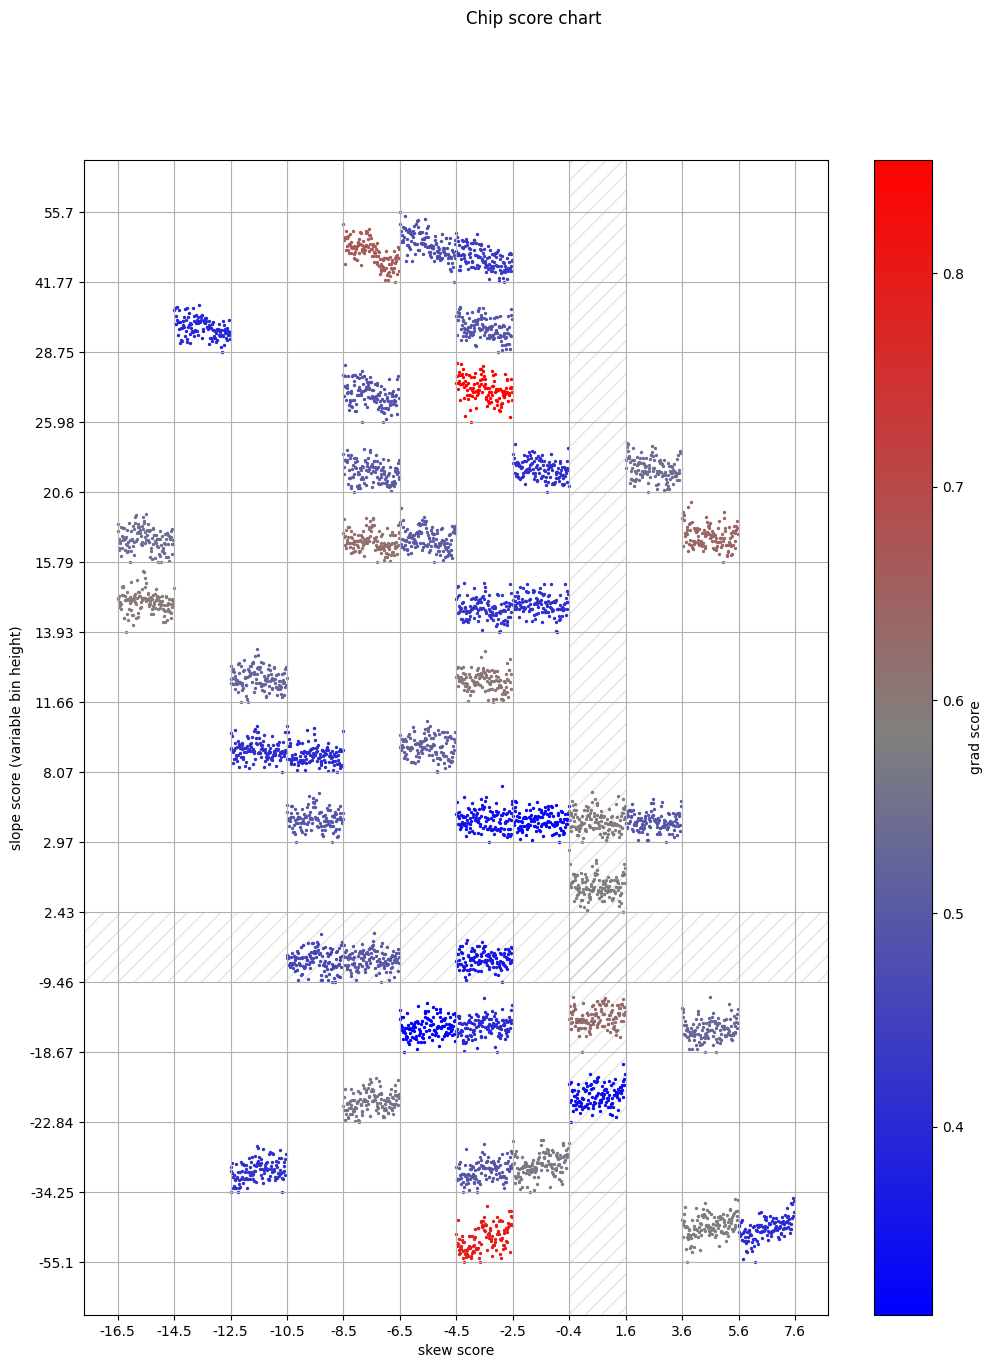

In [9]:
# Build bins using all three scores; slope, skew, grad
nBins = 12

variables = ["slope", "skew", "grad"]

xVariable = "skew"
yVariable = "slope"
colorVariable = "grad"

listingDict = {"slope" : 1, "skew" : 2, "grad" : 3}

maxValues = {"slope" : -1000000, "skew" : -1000000, "grad" : -1000000}
minValues = {"slope" : 1000000, "skew" : 1000000, "grad" : 1000000}
allValues = dict(zip(variables, [[]] * 3))

for listing in chipScores:
    for variable in variables:
        maxValues[variable] = max(maxValues[variable], listing[listingDict[variable]])
        minValues[variable] = min(minValues[variable], listing[listingDict[variable]])
        allValues[variable].append(listing[listingDict[variable]])
        
norm = Normalize(minValues[colorVariable], maxValues[colorVariable])
        
for variable in variables:
    allValues[variable].sort()
        

nDecimals = {"slope" : 1, "skew" : 1, "grad" : 2}
binEdges = np.round(np.linspace(minValues[xVariable], maxValues[xVariable], nBins+1)[1:], nDecimals[xVariable])
maxValueRange = -1000000

# Build xVariable bins
chipBins = {}
for listing in chipScores:
    
    chip = listing[0]
    values = [channel.outnse for channel in chip.getStream(stream) if not channel.badchannel]
    maxValueRange = max(maxValueRange, np.max(values) - np.min(values))
    
    for edge in binEdges:
        if edge not in chipBins.keys():
            chipBins[edge] = []
        if listing[listingDict[xVariable]] < edge:
            chipBins[edge].append(listing)
            break

# Sort along y axis
yBinner = Binhandler()

maxHeight = 0

for i, xBin in enumerate(chipBins):
    points = [listing[listingDict[yVariable]] for listing in chipBins[xBin]]
    yBinner.extend(points)
    maxHeight = max(maxHeight, len(chipBins[xBin]))
    
fig = plt.figure(figsize=(len(chipBins), len(yBinner)))
totalCount = 0
    
for i, xBin in enumerate(chipBins):
    for l, listing in enumerate(chipBins[xBin]):
        chip = listing[0]
        values = np.array([channel.outnse for channel in chip.getStream(stream) if not channel.badchannel])
        thisValueRange = values.max() - values.min()
        yBin = yBinner.getBinNumber(listing[listingDict[yVariable]])
        #print("Bin", i, "chip", l, "yBin:", yBin, "yVariable score", listing[listingDict[yVariable]])
        values = ((values - values.min()) / (values.max() - values.min())
                 ) * thisValueRange/maxValueRange + yBin
        plt.scatter([128*i + x for x in range(len(values))], values, s=2,
                    color=cmap(norm(listing[listingDict[colorVariable]])))
        
        totalCount += 1

print("Number of chips plotted:", totalCount)

#print(yBinner)

plt.xticks([128*i for i in range(nBins + 1)]);
ax = plt.gca()
ax.set_xticklabels([np.round(minValues[xVariable], nDecimals[xVariable])] + list(chipBins.keys()));

yBinEdges = [np.ceil(edge * 100) / 100 for edge in yBinner.edges]
yBinEdgeLabels = [np.round(minValues[yVariable], nDecimals[yVariable])] + yBinEdges + [np.round(maxValues[yVariable], nDecimals[yVariable])]
yTicks = [i for i in range(0, len(yBinner) + 1)]
plt.yticks(yTicks)
#print("Max height:", maxHeight)
#print("ylim", plt.ylim())
#print("yTicks", len(yTicks), yTicks)
#print("len(yBinner)", len(yBinner))
#print("yBins", len(yBinEdgeLabels), yBinEdgeLabels)
plt.grid()
ax.set_yticklabels(yBinEdgeLabels)

plt.suptitle("Chip score chart")

plt.xlabel(xVariable + " score")
plt.ylabel(yVariable + " score (variable bin height)")

cbar = plt.colorbar(mappable=ScalarMappable(norm, cmap), ax=ax, label=colorVariable+" score")

for e, edge in enumerate(binEdges):
    xticks = plt.xticks()[0]
    if edge > 0 and e > 0 and e + 1 < len(xticks):
        import matplotlib.patches as patches
        xticks = plt.xticks()[0]
        ylims = plt.ylim()
        patch = patches.Rectangle((xticks[e], ylims[0]),
                                  xticks[e+1]-xticks[e], ylims[1]-ylims[0],
                                  hatch="//", fill=None, linewidth=0, alpha=0.1)
        ax.add_patch(patch)
        break
        
for e, edge in enumerate(yBinEdges):
    yticks = plt.yticks()[0]
    if edge > 0 and e > 0 and e + 1 < len(yticks):
        import matplotlib.patches as patches
        xlims = plt.xlim()
        patch = patches.Rectangle((xlims[0], yticks[e]),
                                  xlims[1]-xlims[0], yticks[e+1]-yticks[e],
                                  hatch="//", fill=None, linewidth=0, alpha=0.1)
        ax.add_patch(patch)
        break


Text(0.5, 0, 'Slope score (leftScore - rightScore)')

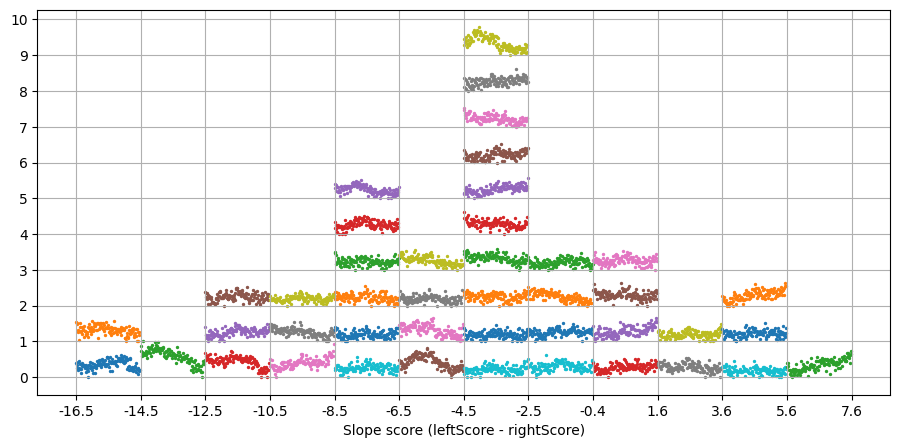

In [10]:
fig = plt.figure(figsize=(11, 5))

maxRange = 0

for xBin in chipBins:
    for listing in chipBins[xBin]:
        chip = listing[0]
        values = np.array([channel.outnse for channel in chip.getStream(0) if not channel.badchannel])
        thisMax = values.max()
        thisMin = values.min()
        thisRange = thisMax - thisMin
        maxRange = max(maxRange, thisRange)

for x, xBin in enumerate(chipBins):
    for l, listing in enumerate(chipBins[xBin]):
        chip = listing[0]
        values = np.array([channel.outnse for channel in chip.getStream(0) if not channel.badchannel])
        thisMax = values.max()
        thisMin = values.min()
        thisRange = thisMax - thisMin
        rangeScale = thisRange / maxRange
        values = ((values - values.min()) / (values.max() - values.min()))
        values = values * rangeScale + l
        plt.scatter([i + x*128 for i in range(len(values))], values, s=2)
        
plt.xticks([i*128 for i in range(len(chipBins) + 1)])
plt.gca().set_xticklabels([np.round(minValues[xVariable], 1)] + list(chipBins.keys()));
plt.yticks([i for i in range(0, int(plt.ylim()[1])+1)])
plt.grid()
plt.xlabel("Slope score (leftScore - rightScore)")

In [11]:
nXBins = 10
nTestPoints = 100
xBins = []
testPoints = [(np.random.randint(nXBins), np.random.random()*10) for _ in range(nTestPoints)]
for x in range(nXBins):
    points = [point for point in testPoints if point[0] == x]
    xBins.append(points)

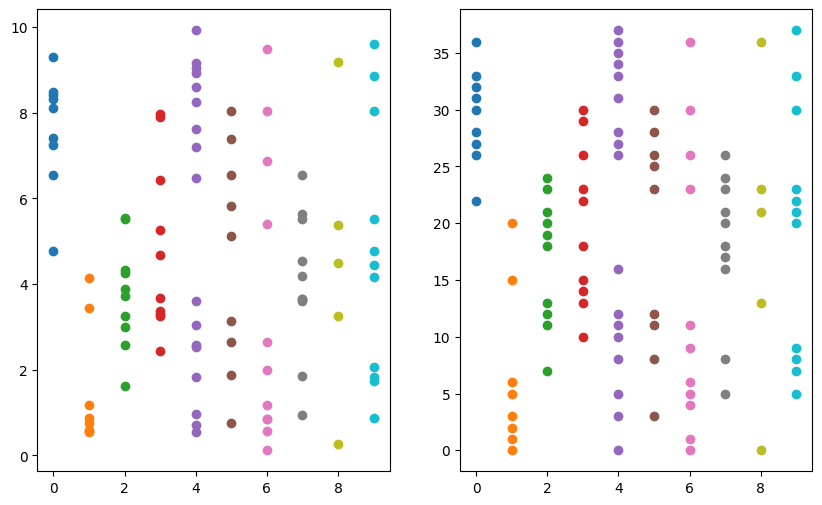

In [12]:
# Binhandler example
binner = Binhandler()
for xBin in xBins:
    points = [point[1] for point in xBin]
    binner.extend(points)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for xBin in xBins:
    axs[0].scatter([point[0] for point in xBin], [point[1] for point in xBin])
    axs[1].scatter([point[0] for point in xBin], [binner.getBinNumber(point[1]) for point in xBin])

In [10]:
import sys
sys.path.append("../")
from Helpers.getHybridsFromIDFile import getHybridsFromIDFile
from Helpers.getECSubtypes import getECSubtypes
from FeatureScore import *

subtypes = getECSubtypes()
hybrids = {}
for subtype in subtypes:
    filename = "../Helpers/jsonFiles/" + subtype + "data.json"
    _, hybrids[subtype] = getHybridsFromIDFile(filename, verbose=False)
    
#subtypes = ["R1H0"] #, "R0H1", "R1H0", "R1H1"]
subtypes = ["R1H1"]
#subtypes = ["R2H0"]

In [11]:
stream = 1

scoreTypes = ["slope", "skew", "grad"]
allScores = {"slope" : {}, "skew" : {}, "grad" : {}}
listings = []
for subtype in subtypes:
    for scoreType in scoreTypes:
        allScores[scoreType][subtype] = []
    for hybrid in hybrids[subtype]:
        hybrid.classification()
        for chip in hybrid.chips:
            if chip.badchip:
                continue
            nBad = sum([channel.badchannel for channel in chip.getStream(stream)])
            if nBad > 20:
                continue
            slopeScore, skewScore = getFScores(chip, stream, "outnse")
            gradScore = getGradientScore(chip, stream)
            allScores["slope"][subtype].append(slopeScore)
            allScores["skew"][subtype].append(skewScore)
            allScores["grad"][subtype].append(gradScore)
            listings.append({"chip":chip, "slope":slopeScore, "skew":skewScore, "grad":gradScore})

Text(0, 0.5, '# chips')

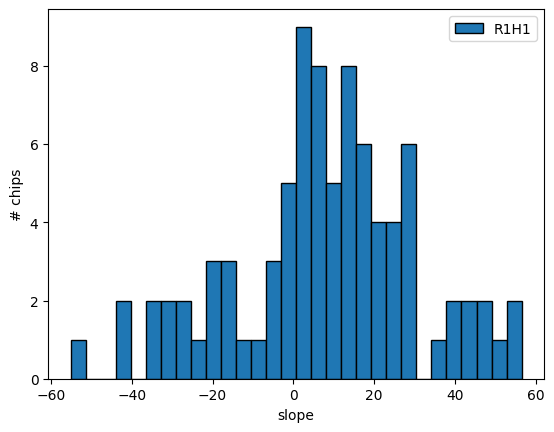

In [13]:
import matplotlib.pyplot as plt
import numpy as np

scoreType = "slope"

fig = plt.figure()
ax = plt.gca()

#binMax = -80
#binMin = min(scores)
#nBins = 30
#bins = np.linspace(binMin, binMax, nBins)

scores = []
labels = []
for subtype in subtypes:
    labels.append(subtype)
    scores.append(allScores[scoreType][subtype])

ax.hist(scores, bins=30, edgecolor='k', stacked=True, label=labels);
ax.legend()
ax.set_xlabel(scoreType)
ax.set_ylabel("# chips")
#ax.set_yscale('log')

Chips with addresses: 86 without: 0


Text(0.5, 0.93, 'Chip scores by chip address, away stream')

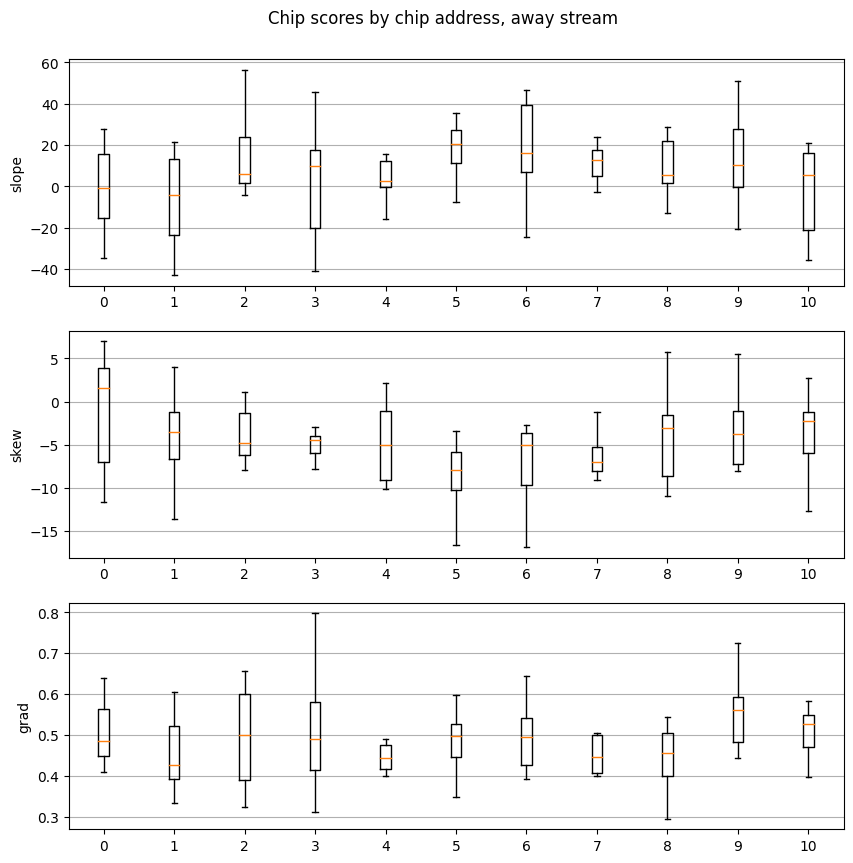

In [14]:
addressScores = {}
have = 0
haveNot = 0
for listing in listings:
    chip = listing["chip"]
    address = chip.address
    if address is not None:
        have += 1
        if address not in addressScores.keys():
            addressScores[address] = {"slope":[], "skew":[], "grad":[]}
        for scoreType in scoreTypes:
            addressScores[address][scoreType].append(listing[scoreType])
    else:
        haveNot += 1
print("Chips with addresses:", have, "without:", haveNot)
fig, axs = plt.subplots(3, figsize=(10, 10))
for ax, scoreType in zip(axs, scoreTypes):
    for a, address in enumerate(addressScores):
        ax.boxplot(addressScores[address][scoreType], positions=[a], showfliers=False)
        ax.set_ylabel(scoreType)
    ax.set_xticklabels(list(addressScores.keys()))
    ax.grid(axis="y")
plt.suptitle("Chip scores by chip address, " + {0:"under", 1:"away"}[stream] + " stream", y=0.93)

In [17]:
print([chip.address for chip in hybrid.chips])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


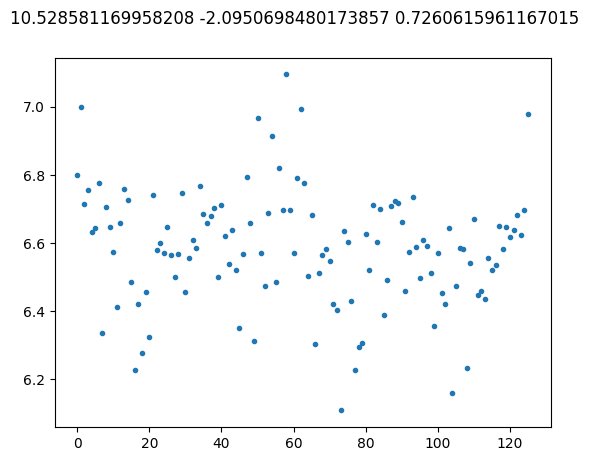

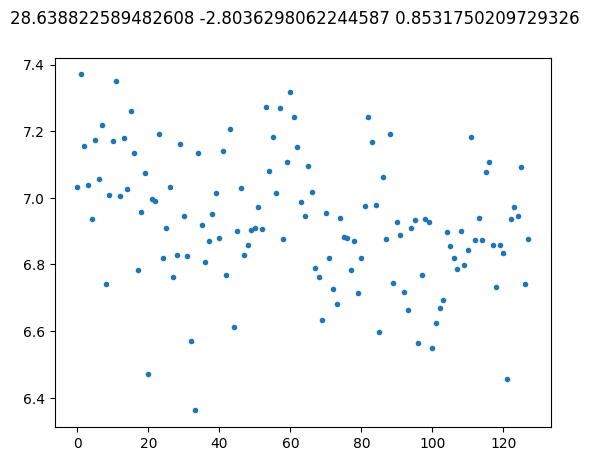

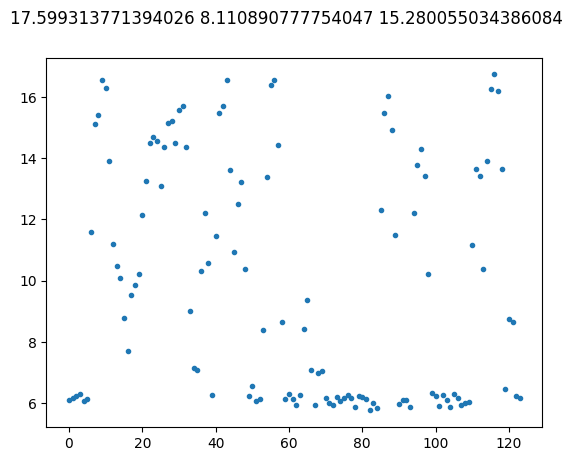

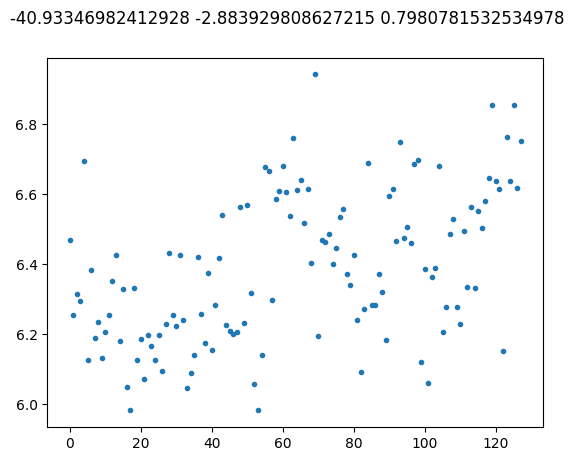

In [18]:
for listing in listings:
    if np.abs(listing["grad"]) > .7:
        fig = plt.figure()
        plt.plot([channel.outnse for channel in listing["chip"].getStream(stream) if not channel.badchannel], '.')
        plt.suptitle(str(listing["slope"]) + " " + str(listing["skew"]) + " " + str(listing["grad"]))
        plt.show()

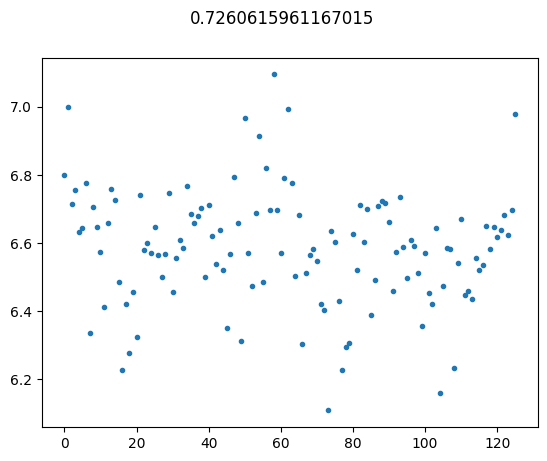

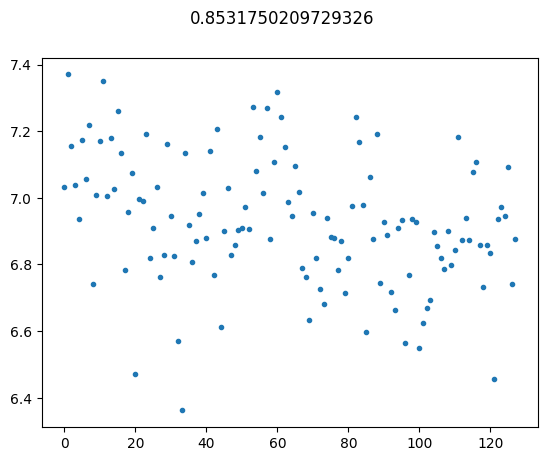

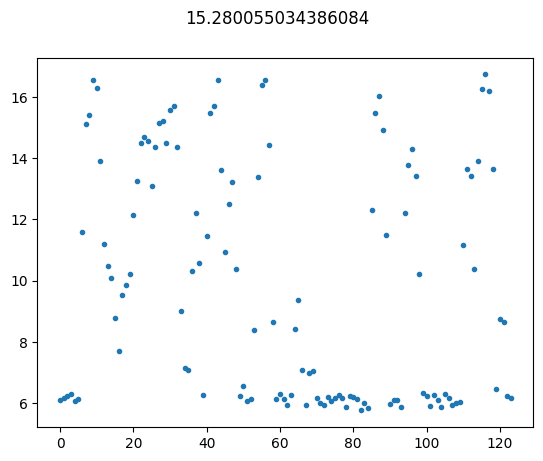

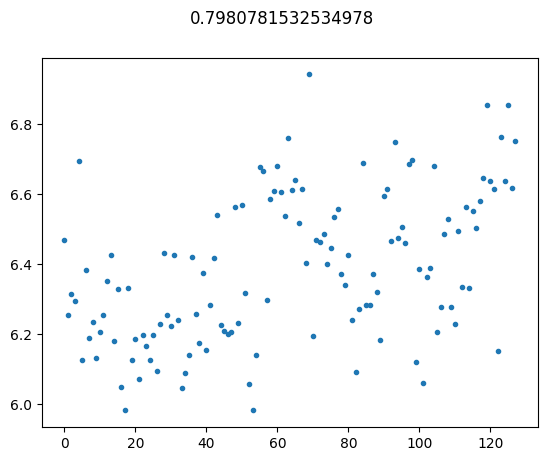

In [19]:
badHybrids = []
for subtype in subtypes:
    for hybrid in hybrids[subtype]:
        for chip in hybrid.chips:
            values = [channel.outnse for channel in chip.getStream(stream) if not channel.badchannel]
            slope, skew = getFScores(chip, stream, "outnse")
            grad = getGradientScore(chip, stream)
            if np.abs(grad) > .7:
                fig = plt.figure()
                plt.plot(values, '.')
                plt.suptitle(str(grad))
                plt.show()
                if not hybrid in badHybrids:
                    badHybrids.append(hybrid)

In [20]:
badHybrids

(<Figure size 1800x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Input noise stream0'}, xlabel='Channel #', ylabel='Input noise [ENC]'>,
        <AxesSubplot: title={'center': 'Input noise stream1'}, xlabel='Channel #', ylabel='Input noise [ENC]'>],
       dtype=object))

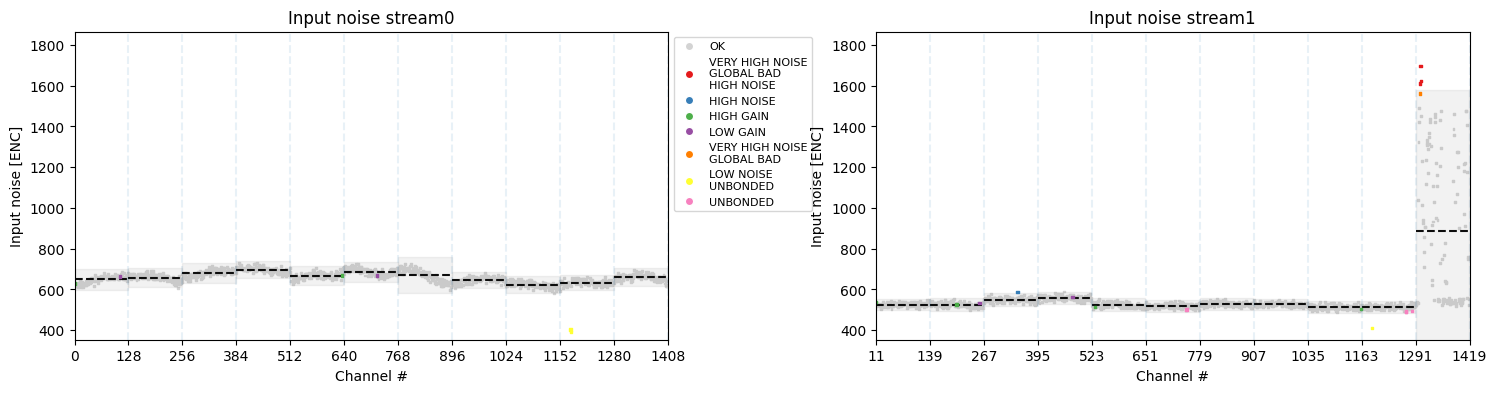

In [24]:
sys.path.append("../../")
from plots.ResponseCurvePlots import plotRCClassified

plotRCClassified(badHybrids[2], "innse", showStream0=True, showStats=True)

In [139]:
help(plotRCClassified)

Help on function plotRCClassified in module plots.ResponseCurvePlots:

plotRCClassified(hybrid, variable, showStream0=True, showStream1=True, showStats=False, zoomedIn=False, minValue=None, maxValue=None, detectAnomalies=False, figure=None)
    Plot channel input noise with classification coloring and labling, for a single hybrid.



In [134]:
import json
subtypes = getECSubtypes()
unbondedIDs = []
bondedIDs = []
for subtype in getECSubtypes():
    filename = "../Helpers/jsonFiles/" + subtype + "data.json"
    with open(filename, "r") as f:
        allIDs = json.load(f)
    unbondedIDs.extend(allIDs["unbonded_itkdb_testids"])
    bondedIDs.extend(allIDs["bonded_itkdb_testids"])

In [135]:
dataPath = "../../data/"
jsons = []
for ID in bondedIDs:
    with open(dataPath+ID+".json", "r") as f:
        js = json.load(f)
    jsons.append(js)

In [136]:
lateIDs = []
for j, js in enumerate(jsons):
    date = js["date"]
    if date[:10] == "2023-03-29":
        print(js["date"])
        lateIDs.append(bondedIDs[j])

2023-03-29T01:15:54.000Z
2023-03-29T01:15:54.000Z


In [137]:
from parsers.RCparsers import parseRC

In [138]:
hybrids = []
for ID in lateIDs:
    filename = dataPath + ID + ".json"
    hybrids.append(parseRC(filename))

Parsing file: ../../data/6424756736225c0038b51577.json
Addresses [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Parsing file: ../../data/642475de62f78200360c42e3.json
Addresses [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [139]:
for hybrid in hybrids:
    print(hybrid.subtype, hybrid.fileFormat)

R1H0 json
R1H1 json


6424756736225c0038b51577
642475de62f78200360c42e3


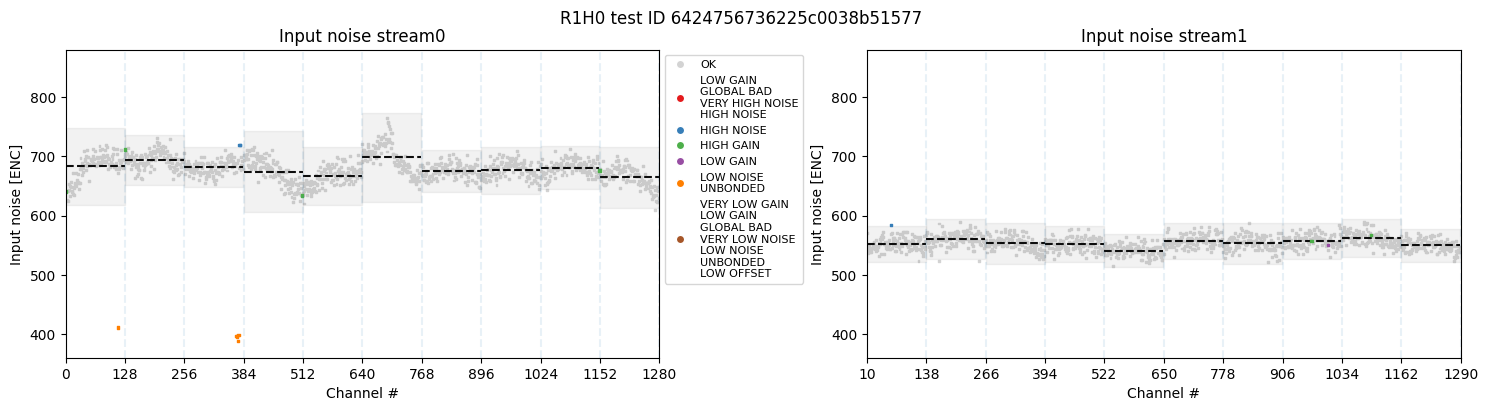

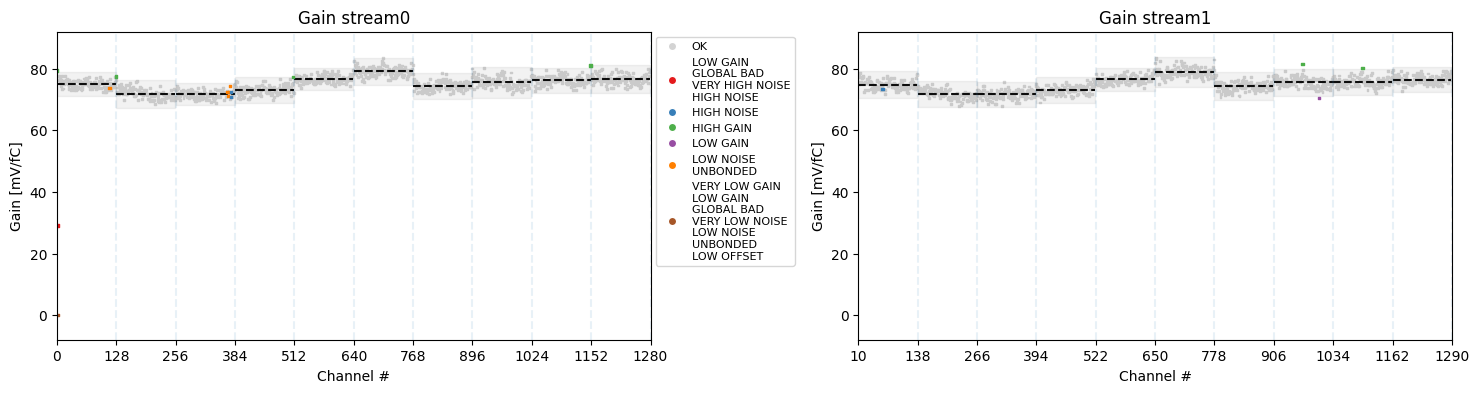

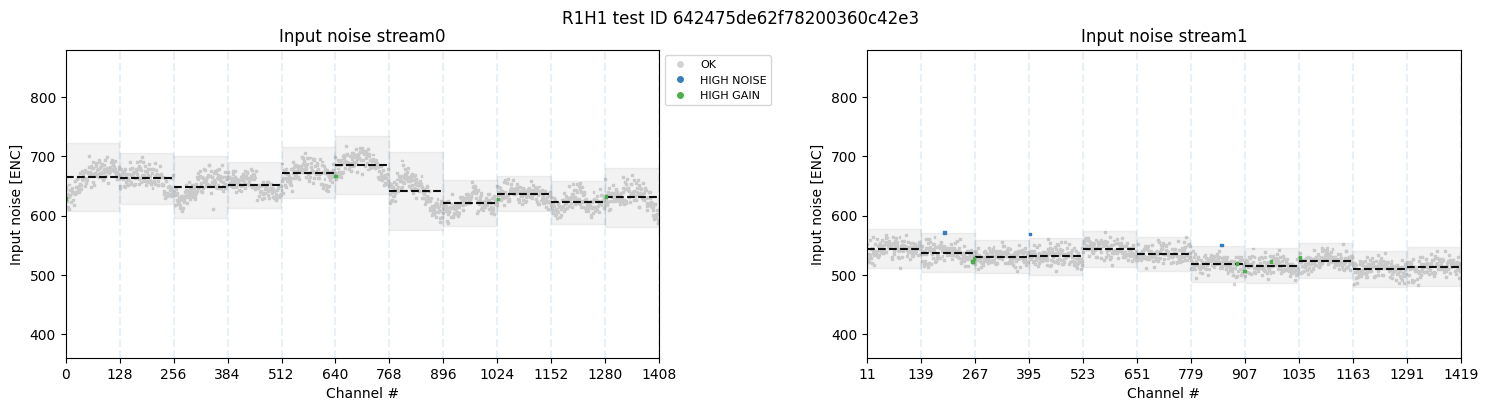

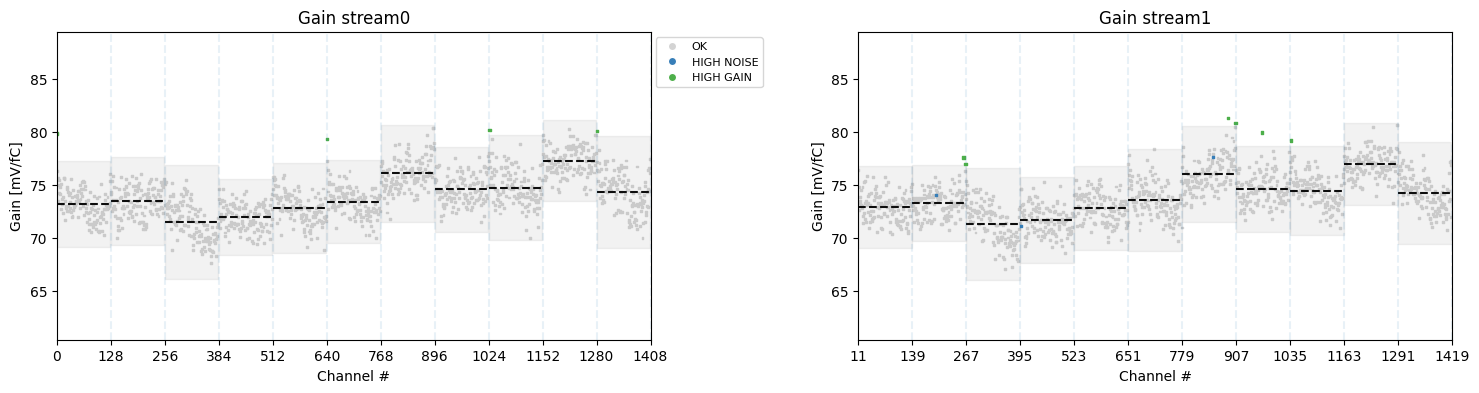

In [142]:
from plots.ResponseCurvePlots import plotRCClassified
for hybrid in hybrids:
    #if hybrid.subtype == "R1H1":
    hybrid.classification()
    fig, axs = plotRCClassified(hybrid, "innse", showStats=True, showStream1=True, minValue=400, maxValue=800)
    plotRCClassified(hybrid, "gain", showStats=True, showStream1=True)
    fig.suptitle(hybrid.subtype+  " test ID " + hybrid.testID)
    print(hybrid.testID)

In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
from Helpers.getHybridsFromIDFile import *
from parsers.RCparsers import parseRC
from plots.ResponseCurvePlots import *

In [16]:
_, hybrids = getHybridsFromIDFile("../Helpers/jsonFiles/R1H0data.json", verbose=False)

In [17]:
for h, hybrid in enumerate(hybrids):
    print(h, hybrid.testDate)

0 2023-01-04T19:27:09.566Z
1 2023-03-29T17:29:11.927Z
2 2022-12-09T20:01:01.467Z
3 2023-03-16T22:11:30.340Z
4 2023-02-23T00:32:17.086Z
5 2022-11-23T22:39:56.537Z
6 2023-02-10T01:10:00.744Z
7 2023-03-01T00:33:08.887Z
8 2023-02-07T04:24:41.578Z
9 2022-12-09T19:10:39.817Z
10 2023-02-10T01:18:46.298Z
11 2022-05-25T23:12:16.000Z


In [6]:
print(hybrids[0])

#chips: 1, fileFormat: json (clone bug), testedAtStage: ON_MODULE, subtype: R2H0


In [7]:
print(hybrids[6])

#chips: 6, fileFormat: json, testedAtStage: ON_MODULE, subtype: R2H0


In [4]:
import glob
import json

In [5]:
files = glob.glob("../../data/*.json")
jsons = []
for file in files:
    with open(file, "r") as f:
        jsons.append(json.load(f))

In [7]:
for j, js in enumerate(jsons):
    if "stateTs" in js.keys():
        print(j, "stateTs", js["stateTs"])
    elif "date" in js.keys():
        print(j, "date", js["date"])
    else:
        print(j)

0 date 2022-05-26T11:02:07.000Z
1 date 2022-07-27T15:30:20.000Z
2 date 2022-09-22T19:39:25.000Z
3 stateTs 2022-11-25T01:09:05.785Z
4 date 2022-07-15T16:12:47.000Z
5 stateTs 2022-11-15T00:19:13.986Z
6 stateTs 2022-12-09T20:02:13.980Z
7 date 2022-07-05T12:59:36.000Z
8 date 2022-09-23T22:15:58.000Z
9 date 2022-03-22T23:45:58.000Z
10 date 2022-07-13T10:55:04.000Z
11 date 2022-05-25T23:12:16.000Z
12 date 2022-09-23T12:07:06.000Z
13 stateTs 2023-02-23T00:33:47.069Z
14 date 2022-06-29T20:23:16.000Z
15 date 2022-09-22T19:39:25.000Z
16 stateTs 2023-01-12T23:08:32.071Z
17 date 2022-05-17T14:09:07.000Z
18 date 2022-06-20T19:36:28.000Z
19 date 2022-08-04T22:58:58.000Z
20 date 2022-07-15T16:12:47.000Z
21 date 2022-06-29T15:50:00.000Z
22 date 2022-05-10T22:32:08.000Z
23 stateTs 2023-02-07T04:39:23.177Z
24 date 2022-06-24T21:09:07.000Z
25 stateTs 2023-03-16T23:26:15.372Z
26 date 2022-04-22T22:47:41.000Z
27 date 2022-05-25T23:12:16.000Z
28 date 2022-07-15T16:12:47.000Z
29 date 2022-09-23T12:07:06.000Z

In [22]:
for item in sys.path:
    theseDirs = item.split("/")
    if "itk-strip-module-analysis" in theseDirs:
        for thisDir in theseDirs:
            print(thisDir)
        print("===")


home
kaastran
Documents
aqt
itk-strip-module-analysis
analysis
FeatureLibrary
===

home
kaastran
Documents
aqt
venv
itk-strip-module-analysis
lib
python3.8
site-packages
===


['/home/kaastran/Documents/aqt/itk-strip-module-analysis/analysis/FeatureLibrary',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/kaastran/Documents/aqt/venv/itk-strip-module-analysis/lib/python3.8/site-packages',
 '../',
 '../../',
 '../',
 '../',
 '../',
 '../']